In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import yaml
with open('config.yml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
config

{'EXPERIMENT_NAME': 'exp1',
 'BASE_PATH': '/home/pablo/code/aramis/topolog_morphology',
 'WSI_ID': [1, 2, 3],
 'MORPHOLOGICAL_PROPERTIES': ['centroid',
  'area',
  'perimeter',
  'area_bbox',
  'area_convex',
  'axis_major_length',
  'axis_minor_length',
  'eccentricity',
  'extent',
  'solidity'],
 'TOPOLOGICAL_PROPERTIES': [],
 'CENTROID_ID': False,
 'GRAPH': {'dropout': 0.5, 'weight': True, 'graph_type': 'delaunay'},
 'VISUALIZATION_CENTROID': {'active': True,
  'title': True,
  'figsize': 20,
  'size': 2,
  'dpi': 300},
 'VISUALIZATION_GRAPH': {'active': True,
  'title': True,
  'figsize': 20,
  'dpi': 300,
  'axis': False,
  'options': {'font_size': 0,
   'node_size': 25,
   'node_color': 'blue',
   'edgecolors': 'black',
   'linewidths': 1,
   'width': 1}}}

In [4]:
import os
import numpy as np
import pandas as pd
import glob
from scipy import ndimage
from tqdm import tqdm
from skimage.measure import regionprops, regionprops_table
from skimage.segmentation import clear_border
from skimage.measure import label
from scipy import ndimage
import matplotlib.pyplot as plt
from PIL import Image

# Shape andgraph processing
import networkx as nx
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from rasterio.features import rasterize
from geocube.api.core import make_geocube
from sklearn.neighbors import kneighbors_graph
from libpysal import weights, examples
from libpysal.cg import voronoi_frames
from scipy.spatial import distance

import seaborn as sns


from params import DATA_PATH, MORPHOLOGICAL_CSV_PATH, TOPOLOGICAL_CSV_PATH, VISUALIZATION_WSI_PATH, VISUALIZATION_GRAPH_PATH, WSI_ID, MORPHOLOGICAL_PROPERTIES, CENTROID_ID


if WSI_ID == "all":
    predictions_paths = sorted(glob.glob(DATA_PATH + "/*"))
elif type(WSI_ID) == list:
    try: 
        predictions_paths = sorted(glob.glob(DATA_PATH + "/*"))
        predictions_paths = [predictions_paths[i] for i in WSI_ID]
    except:
        print('Not a valid WSI_ID list in config.yml')
else : 
    print('Not a valid WSI_ID value in config.yml')


KeyError: 'experiment_name'

In [50]:

for path in tqdm(predictions_paths):
    
    wsi_name = path.split('/')[-1] # get name of wsi from folder's name
    df = pd.DataFrame() # instantiate empty dataframe to store morphological features of one specific wsi
    images_paths = sorted(glob.glob(path + '/*.png')) # get the path to each patch of the wsi
                          
    for i, patch_path in tqdm(enumerate(images_paths), leave=False):
        
        xcoord = patch_path.split('/')[-1][:-4].split('_')[-2] # requires to have a standard naming convention of patch_paths (data/wsi_name/wsi_name_xcoord_ycoord.png)
        ycoord = patch_path.split('/')[-1][:-4].split('_')[-1]
        
        image = np.array(Image.open(patch_path)) # load patch as numpy array
        instance_map = label(ndimage.binary_opening(image, iterations=3)) # quick data processing to remove small objects and close small holes
        
        regions = regionprops(instance_map)
        tmp_df_1 = pd.DataFrame() # temporary dataframe to store properties of one region
        
        for j, props in enumerate(regions):
            tmp_df_2 = pd.DataFrame(regionprops_table(instance_map, properties=MORPHOLOGICAL_PROPERTIES))
            
            if CENTROID_ID : # give an id to each centroid if specified in config.yml
                centroid_id = patch_path.split('/')[-1][:-4] + f'_{j}'
                tmp_df_2['centroid_id'] = centroid_id
                
            tmp_df_2['centroid-0'] += int(xcoord)
            tmp_df_2['centroid-1'] += int(ycoord)
            
            tmp_df_1 = pd.concat([tmp_df_1, tmp_df_2], ignore_index=True)
            
        df = pd.concat([df, tmp_df_1], ignore_index=True)
    
    df.to_csv(os.path.join(MORPHOLOGICAL_CSV_PATH, f'{wsi_name}.csv'), index=False) # save dataframe with all the morphological features of one wsi

100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


In [51]:
pd.read_csv('/home/pablo/code/aramis/topolog_morphology/csv/morphology/wsi4.csv')

,centroid-0,centroid-1,area,perimeter,area_bbox,area_convex,axis_major_length,axis_minor_length,eccentricity,extent,solidity
0,5407.850730,10221.841751,891,118.024387,1287,931,38.128248,30.361352,0.604908,0.692308,0.957035
1,5437.463048,10157.722864,866,127.338095,1428,948,42.556709,27.156020,0.769942,0.606443,0.913502
2,5437.224719,10121.921348,267,61.254834,441,280,21.220876,16.350207,0.637467,0.605442,0.953571
3,5492.644252,10144.468547,922,148.752309,1344,1041,57.631567,21.579847,0.927249,0.686012,0.885687
4,5407.850730,10221.841751,891,118.024387,1287,931,38.128248,30.361352,0.604908,0.692308,0.957035
...,...,...,...,...,...,...,...,...,...,...,...
663,5396.947253,10036.571429,455,97.539105,930,516,36.961565,16.401623,0.896152,0.489247,0.881783
664,5412.345679,10047.283951,81,32.041631,120,83,11.636267,8.947737,0.639306,0.675000,0.975904
665,5431.037037,10093.382716,81,32.870058,144,86,10.538456,10.093765,0.287425,0.562500,0.941860
666,5478.498498,10093.983483,666,101.296465,896,692,32.704099,26.026995,0.605516,0.743304,0.962428


Text(0.5, 1.0, 'wsi4')

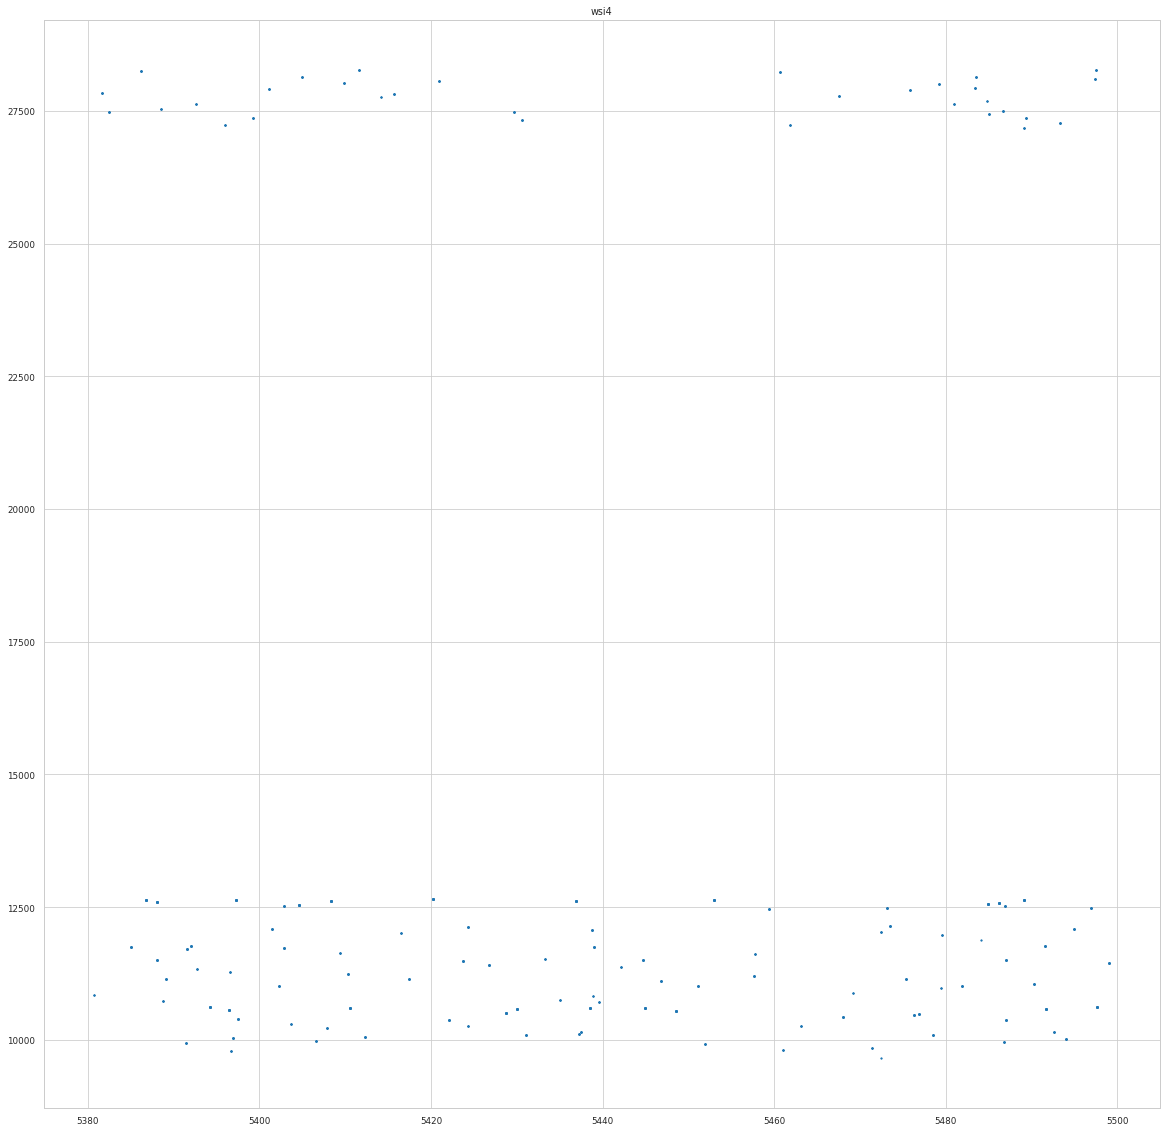

In [52]:

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.scatter(x=df['centroid-0'], y=df['centroid-1'], s=2)
ax.set_title(f'{wsi_name}')

In [59]:
df.drop_duplicates(inplace=True)

In [66]:
centroids = df[['centroid-0', 'centroid-1']].values
points = [(float(x[0]), float(x[1])) for x in centroids]
points_array = np.array(points)
x_max = points_array[:, 0].max()
y_max = points_array[:, 1].max()
divider = np.array([x_max, y_max])
points = [(float(x[0]), float(x[1])) for x in points_array / divider]
pos = {i: point for i, point in enumerate(points)}
cells, generators = voronoi_frames(points)


delaunay = weights.Rook.from_dataframe(cells)
G = delaunay.to_networkx()

weighted_G = nx.Graph()
weighted_G.add_nodes_from(G.nodes())


for edges in G.edges():
    weighted_G.add_edge(*edges, weight=1/distance.euclidean(centroids[edges[0]], centroids[edges[1]]))

G = weighted_G.copy()


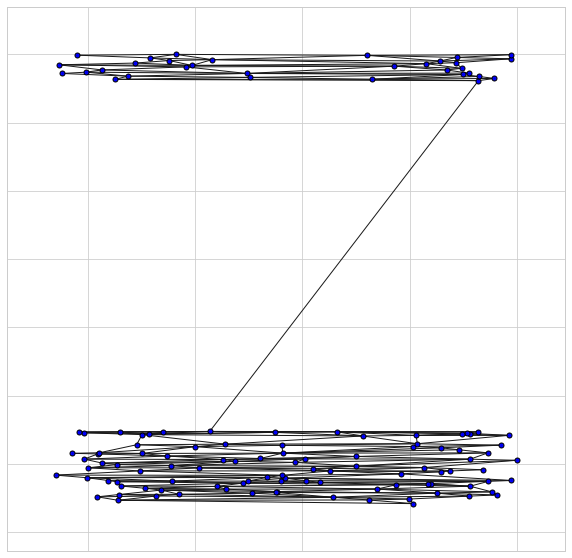

In [67]:

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
fig.patch.set_facecolor('white')

# Draw graph
options = {
    "font_size": 0,
    "node_size": 25,
    "node_color": 'blue',
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
}

nx.draw_networkx(G, pos, ax=ax, **options)
# ax.set_title(f'Delaunay Graph - SLIDE ID {SLIDE_ID} ')
# ax.axis('off')

# plt.savefig(f'graph_viz/delaunay/delaunay_graph_{SLIDE_ID}.png', dpi=300)
# plt.close()






In [24]:
array_paths = glob.glob('/home/pablo/code/aramis/dataset/unet_npy/*.npy')

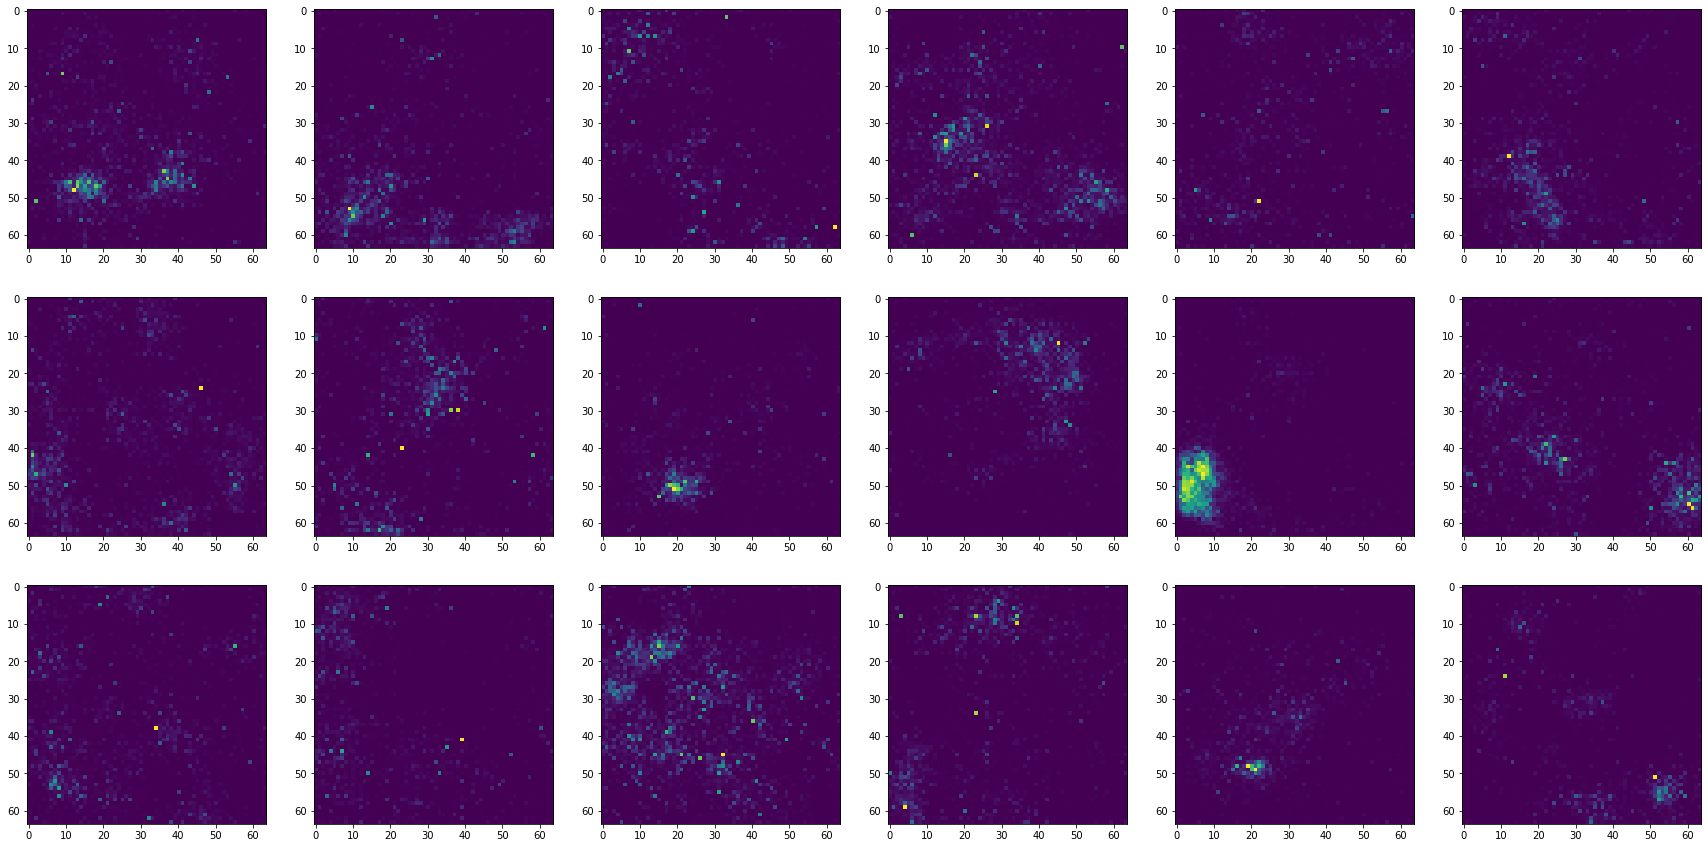

In [61]:
fig, ax = plt.subplots(3, 6, figsize=(30, 15))
ax = np.ravel(ax)

for i, array in enumerate(array_paths):
    arr = np.load(array).squeeze()
    ax[i].imshow(arr)